# Stack Overflow Data EDA and Text Generation 
- Joel Stremmel
- 01-14-20

**About:**

This notebook explores the Stack Overflow data available through `tff.simulation.datasets` with some basic EDA and then by training a model with Federared Averaging by following the Federated Learning for Text Generation example notebook listed in the references section.

**Notes:**

There are two modeling options within this notebook based on the tutorials listed under references:
1. To load a pretrained RNN as in the FL example using the Shakespeare dataset.
2. To build and train a basic RNN model from scratch with the architecure in the TF text generation tutorial.


**Data:** 
- https://www.kaggle.com/stackoverflow/stackoverflow

**License:** 
- https://creativecommons.org/licenses/by-sa/3.0/

**Data and Model References:**
- https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data
- https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb
- https://github.com/tensorflow/federated/
- https://www.tensorflow.org/tutorials/text/text_generation

**Environment Setup References:**
- https://www.tensorflow.org/install/gpu
- https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d
- https://www.tensorflow.org/install/source#tested_build_configurations
- https://anbasile.github.io/programming/2017/06/25/jupyter-venv/

### Setup

In [1]:
# !pip install --upgrade pip
# !pip install --upgrade tensorflow-federated
# !pip uninstall tensorflow -y
# !pip install --upgrade tensorflow-gpu==2.0
# !pip install --upgrade nltk
# !pip install matplotlib
# !pip install nest_asyncio

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import collections
import functools
import os
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [4]:
import tensorflow as tf
print('Built with Cuda: {}'.format(tf.test.is_built_with_cuda()))
print('Build with GPU support: {}'.format(tf.test.is_built_with_gpu_support()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Built with Cuda: True
Build with GPU support: True
Num GPUs Available:  1


In [5]:
import tensorflow_federated as tff

In [6]:
tf.compat.v1.enable_v2_behavior()

In [7]:
np.random.seed(0)

### Set Tensorflow to Use GPU

In [8]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [9]:
physical_devices = tf.config.experimental.list_physical_devices(device_type=None)
tf.config.experimental.set_memory_growth(physical_devices[-1], enable=True)
for device in physical_devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Test TFF

In [10]:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

### Load Stack Overflow Word Counts

In [11]:
word_counts = tff.simulation.datasets.stackoverflow.load_word_counts(cache_dir='~/data')

### Number of Words

In [12]:
len(word_counts)

6005329

### Create Dictionary of Counts

In [13]:
count_dict = collections.Counter(word_counts)

### Create Function to Plot Word Frequency

In [14]:
def plot_ordered_frequency(count_dict, n, color='orange'):
    
    top_words = collections.OrderedDict(sorted(count_dict.most_common(n), key=lambda x: x[1]))
    
    plt.figure(figsize=(8, 16))
    plt.barh(range(len(top_words)), top_words.values(), align='center', color=color)
    plt.yticks(range(len(top_words)), list(top_words.keys()))
    
    plt.title('Most Common Words', size=18)
    plt.xlabel('Count of Occurences', size=18)
    plt.ylabel('Words', size=18)

    plt.show()

### Plot Raw Frequency of Words

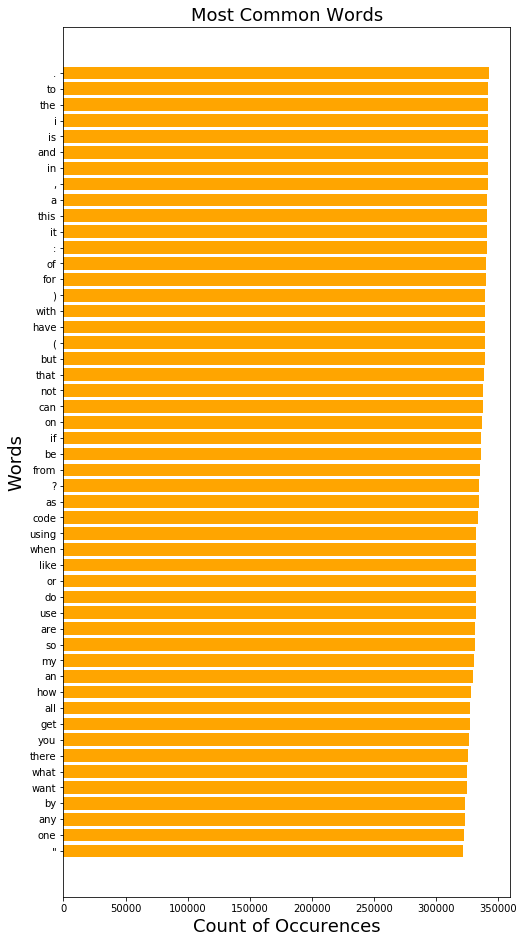

In [15]:
plot_ordered_frequency(count_dict, n=50)

### Clean Dictionary by:
- Removing Stopwords
- Removing Punctuation

In [16]:
for stopword in stopwords.words('english'):
    count_dict.pop(stopword, None)

In [17]:
for punctuation in string.punctuation:
    count_dict.pop(punctuation, None)

### Plot Frequency of Filtered Words

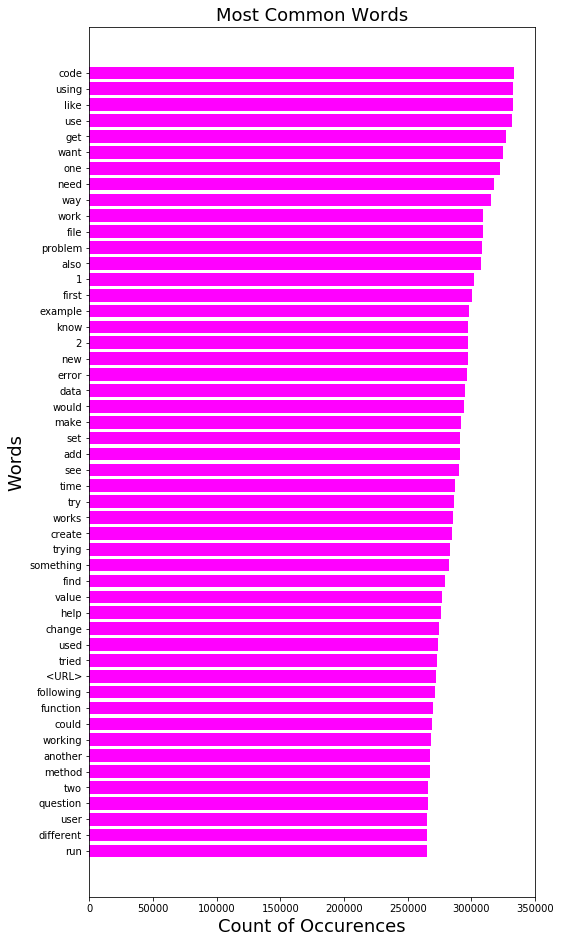

In [18]:
plot_ordered_frequency(count_dict, n=50, color='magenta')

### View Some Rare Words

In [19]:
count_dict.most_common()[-10:-1]

[('zzzzzzzzzzzzzzzzzzzz', 1),
 ('zzzzzzzzzzzzzzzzzzzzzz', 1),
 ('zzzzzzzzzzzzzzzzzzzzzzzzzzz', 1),
 ('zzzzzzzzzzzzzzzzzzzzzzzzzzzzz', 1),
 ('zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz', 1),
 ('zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz', 1),
 ('zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz', 1),
 ('zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz', 1),
 ('zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz', 1)]

### Compute Summary Statistics

In [20]:
counts = list(count_dict.values())
min_occurences = min(counts)
max_occurences = max(counts)
mean_occurences = np.mean(counts)
median_occurences = np.median(counts)
stdv_occurences = np.std(counts)
print('Minimum number of occurences: {}'.format(min_occurences))
print('Maximum number of occurences: {}'.format(max_occurences))
print('Mean number of occurences: {}'.format(round(mean_occurences, 3)))
print('Median number of occurences: {}'.format(round(median_occurences, 3)))
print('Standard Deviation of occurences: {}'.format(round(stdv_occurences, 3)))

Minimum number of occurences: 1
Maximum number of occurences: 333526
Mean number of occurences: 45.946
Median number of occurences: 1.0
Standard Deviation of occurences: 1946.294


### Plot Histogram of Counts
- First with the raw counts
- Then with the log of the counts due to the increasingly small number of large values

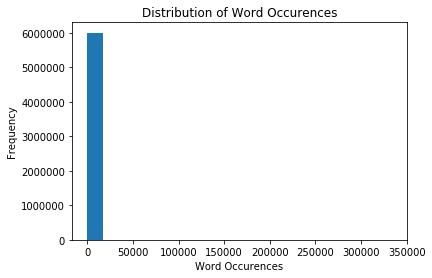

In [21]:
plt.hist(counts, bins=20)
plt.title('Distribution of Word Occurences')
plt.xlabel('Word Occurences')
plt.ylabel('Frequency')
plt.show()

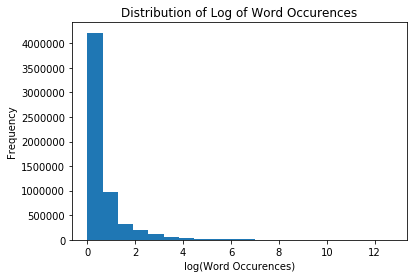

In [22]:
fig, ax = plt.subplots(1,1)
plt.hist(np.log(counts), bins=20)
plt.title('Distribution of Log of Word Occurences')
plt.xlabel('log(Word Occurences)')
plt.ylabel('Frequency')
plt.show()

### Load Stack Overflow Data

In [23]:
train_data, val_data, test_data = tff.simulation.datasets.stackoverflow.load_data(cache_dir='~/data')
# print(train_data.output_shapes)

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### View Some Sample Client Records

In [24]:
raw_example_dataset = train_data.create_tf_dataset_for_client('00000001')
for record in raw_example_dataset.take(2):
    for key in record:
        print('\nKey: {}'.format(key))
        print(record[key])


Key: creation_date
tf.Tensor(b'2008-12-22 14:45:37.037 UTC', shape=(), dtype=string)

Key: score
tf.Tensor(11, shape=(), dtype=int64)

Key: tags
tf.Tensor(b'sql-server|indexing', shape=(), dtype=string)

Key: title
tf.Tensor(b'what fields should be indexed on a given table ?', shape=(), dtype=string)

Key: tokens
tf.Tensor(b'the sql server 2008 management studio query tool , if you turn on " include actual execution plan " , will tell you what indexes a given query needs to run fast .', shape=(), dtype=string)

Key: type
tf.Tensor(b'answer', shape=(), dtype=string)

Key: creation_date
tf.Tensor(b'2008-12-22 14:45:37.037 UTC', shape=(), dtype=string)

Key: score
tf.Tensor(11, shape=(), dtype=int64)

Key: tags
tf.Tensor(b'sql-server|indexing', shape=(), dtype=string)

Key: title
tf.Tensor(b'what fields should be indexed on a given table ?', shape=(), dtype=string)

Key: tokens
tf.Tensor(b"( assuming there's an obvious missing index that is making the query run unusually slow , that is .

### Count Number of Clients

In [25]:
print('{} train clients.'.format(len(train_data.client_ids)))
print('{} val clients.'.format(len(val_data.client_ids)))
print('{} test clients.'.format(len(test_data.client_ids)))

342477 train clients.
38758 val clients.
204088 test clients.


### Get Sample Clients for Training, Validation, and Testing

In [26]:
NUM_TRAIN_CLIENTS = 50
NUM_VAL_CLIENTS = 10
NUM_TEST_CLIENTS = 10

In [27]:
def get_sample_clients(dataset, num_clients):
    return np.array(dataset.client_ids)[np.random.choice(len(dataset.client_ids),
                                                         size=num_clients,
                                                         replace=False)]

In [28]:
train_clients = get_sample_clients(train_data, num_clients=NUM_TRAIN_CLIENTS)
val_clients = get_sample_clients(val_data, num_clients=NUM_VAL_CLIENTS)
test_clients = get_sample_clients(test_data, num_clients=NUM_TEST_CLIENTS)

### Set Vocabulary
- Currently using the fixed vocabularly of ASCII chars that occur in the works of Shakespeare and Dickens
- **Is there a good way to get the distinct characters from a TF dataset?**

In [29]:
vocab = list('dhlptx@DHLPTX $(,048cgkoswCGKOSW[_#\'/37;?bfjnrvzBFJNRVZ"&*.26:\naeimquyAEIMQUY]!%)-159\r')
vocab_size = len(vocab)

### Creating a Mapping from Unique Characters to Indices

In [30]:
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

### Load and Generate Text with a Pre-Trained Model or Build a New Model
Text generation requires a batch_size=1 model.

In [31]:
def load_pretrained_model(batch_size):
    """
    Load a pretrained model from the Google RNNs trained on Dickens
    based on the desired batch size.
    """
    
    urls = {
        1: 'https://storage.googleapis.com/tff-models-public/dickens_rnn.batch1.kerasmodel',
        8: 'https://storage.googleapis.com/tff-models-public/dickens_rnn.batch8.kerasmodel'}
    
    assert batch_size in urls, 'batch_size must be in ' + str(urls.keys())
    
    url = urls[batch_size]
    local_file = tf.keras.utils.get_file(os.path.basename(url), origin=url)  
    
    return tf.keras.models.load_model(local_file, compile=False)

In [32]:
def build_model(batch_size, vocab_size, embedding_dim=256, rnn_units=512):
    """
    Build model with architecture from: https://www.tensorflow.org/tutorials/text/text_generation.
    """

    model = tf.keras.Sequential([
        
        tf.keras.layers.Embedding(vocab_size,
                                  embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True, 
                            recurrent_initializer='glorot_uniform'),
                                 
#         tf.keras.layers.LSTM(rnn_units,
#                              return_sequences=True,
#                              stateful=True,
#                              recurrent_initializer='glorot_uniform'),
                                 
        tf.keras.layers.Dense(vocab_size)])
                 
    return model

In [33]:
def generate_text(model, start_string):
    """
    Generate text by sampling from the model output distribution
    as in From https://www.tensorflow.org/tutorials/sequences/text_generation.
    """

    num_generate = 200
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)
    text_generated = []
    temperature = 1.0

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [34]:
# keras_model_batch1 = load_pretrained_model(batch_size=1)
keras_model_batch1 = build_model(batch_size=1, vocab_size=vocab_size)
print(generate_text(keras_model_batch1, 'What of TensorFlow Federated, you ask? '))

What of TensorFlow Federated, you ask? %P$Flj1QK$Uszk[ri/3Nv ixF,R
%EYgWWZyc!nX1d%aExzp,r3/cnfN?rOpwUCI-!WJqSnUPty'9$X'M.y8V_SnTS223Ye]aWqxX-AzEp#$-i%8%PgX.'gCE1XXDsak?$)Pe0Y!TeJ7(zNZycKd0O/:"8
&LL(


### Preprocess Federated Stack Overflow
- Using a namedtuple with keys x and y as the output type of the dataset keeps both TFF and Keras happy.
- Construct a lookup table to map string chars to indexes, using the vocab loaded above.
- Write functions for:
    - ID lookup
    - Splitting inputs and targets
    - Applying preprocessing steps to dataset
    - Taking clients and client records and applying preprocessing

In [35]:
SEQ_LENGTH = 100
BATCH_SIZE = 16
BUFFER_SIZE = 5000

In [36]:
BatchType = collections.namedtuple('BatchType', ['x', 'y'])

In [37]:
table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(
        keys=vocab,
        values=tf.constant(list(range(len(vocab))),
        dtype=tf.int64)),
    default_value=0)

In [38]:
def to_ids(x):
    
    s = tf.reshape(x['tokens'], shape=[1])
    chars = tf.strings.bytes_split(s).values
    ids = table.lookup(chars)
    
    return ids

In [39]:
def split_input_target(chunk):
    
    input_text = tf.map_fn(lambda x: x[:-1], chunk)
    target_text = tf.map_fn(lambda x: x[1:], chunk)
    
    return BatchType(input_text, target_text)

In [40]:
def preprocess(dataset):
    
    return (
        # Map ASCII chars to int64 indexes using the vocab
        dataset.map(to_ids)
        # Split into individual chars
        .unbatch()
        # Form example sequences of SEQ_LENGTH +1
        .batch(SEQ_LENGTH + 1, drop_remainder=True)
        # Shuffle and form minibatches
        .shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
        # And finally split into (input, target) tuples,
        # each of length SEQ_LENGTH.
        .map(split_input_target))

In [41]:
def preprocess_data_for_client(client, source=train_data):
    
    return preprocess(source.create_tf_dataset_for_client(client))

In [42]:
train_datasets = [preprocess_data_for_client(client, train_data) for client in train_clients]
print(tf.data.experimental.get_structure(train_datasets[0]))

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


BatchType(x=TensorSpec(shape=(16, 100), dtype=tf.int64, name=None), y=TensorSpec(shape=(16, 100), dtype=tf.int64, name=None))


### Compile and Test on Preprocessed Data

In [43]:
class FlattenedCategoricalAccuracy(tf.keras.metrics.SparseCategoricalAccuracy):

    def __init__(self, name='accuracy', dtype=None):
        super(FlattenedCategoricalAccuracy, self).__init__(name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        
        y_true = tf.reshape(y_true, [-1, 1])
        y_pred = tf.reshape(y_pred, [-1, len(vocab), 1])
        
        return super(FlattenedCategoricalAccuracy, self).update_state(y_true, y_pred, sample_weight)

In [44]:
def compile(keras_model):
    
    keras_model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=0.005), # updated from SGD; TO DO: experiment with a scheduler
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[FlattenedCategoricalAccuracy()]
    )
    
    return keras_model

### Load and Compile Model

In [45]:
keras_model = build_model(batch_size=BATCH_SIZE, vocab_size=vocab_size)
compile(keras_model)

### Compare Loss on Stack Overflow to a Character from the Training Set and to Random Data
As a sanity check, we can construct some completely random data, where we expect the accuracy to be essentially random.

In [46]:
print('Evaluating on an example Stack Overflow character:')
keras_model.evaluate(train_datasets[0].take(1))

Evaluating on an example Stack Overflow character:
1/1 [==============================] - 0s 345ms/step - loss: 4.4527 - accuracy: 0.0131


[4.452722549438477, 0.013125]

In [47]:
random_indexes = np.random.randint(low=0, high=len(vocab), size=1 * BATCH_SIZE * (SEQ_LENGTH + 1))
random_data = {'tokens': tf.constant(''.join(np.array(vocab)[random_indexes]), shape=[1, 1])}
random_dataset = preprocess(tf.data.Dataset.from_tensor_slices(random_data))

In [48]:
print('\nExpected accuracy for random guessing: {:.3f}'.format(1.0 / len(vocab)))
print('Evaluating on completely random data:')
keras_model.evaluate(random_dataset, steps=1)


Expected accuracy for random guessing: 0.012
Evaluating on completely random data:
1/1 [==============================] - 0s 20ms/step - loss: 4.4547 - accuracy: 0.0106


[4.454674243927002, 0.010625]

### Improve Model with Federated Averaging
- Clone the keras_model inside `create_tff_model()`, which TFF will call to produce a new copy of the model inside the graph that it will serialize.
- TFF uses a `dummy_batch` so it knows the types and shapes that your model expects.
- Build and serialize the Tensorflow graph with `build_federated_averaging_process`.

In [49]:
def create_tff_model():
    
    x = tf.constant(np.random.randint(1, len(vocab), size=[BATCH_SIZE, SEQ_LENGTH]))
    dummy_batch = collections.OrderedDict([('x', x), ('y', x)]) 
    keras_model_clone = compile(tf.keras.models.clone_model(keras_model))
    
    return tff.learning.from_compiled_keras_model(keras_model_clone, dummy_batch=dummy_batch)

In [50]:
fed_avg = tff.learning.build_federated_averaging_process(model_fn=create_tff_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Run One Round of Federated Averaging

In [51]:
state = fed_avg.initialize()
state, metrics = fed_avg.next(state, [train_datasets[0].take(1)])
print(metrics)

<accuracy=0.023749999701976776,loss=4.451474189758301>


### Build and Preprocess the Validation and Test Datasets
Concatenate the validation and test datasets for evaluation with Keras.

In [52]:
val_dataset = functools.reduce(lambda d1, d2: d1.concatenate(d2), 
                               [preprocess_data_for_client(client, val_data) for client in val_clients])

test_dataset = functools.reduce(lambda d1, d2: d1.concatenate(d2), 
                                [preprocess_data_for_client(client, test_data) for client in test_clients])

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Train with Federated Averaging

In [53]:
# NOTE: If the statement below fails, it means that you are
# using an older version of TFF without the high-performance
# executor stack. Call `tff.framework.set_default_executor()`
# instead to use the default reference runtime.
if six.PY3:
    tff.framework.set_default_executor(tff.framework.create_local_executor())

In [54]:
NUM_ROUNDS = 20

# The state of the FL server, containing the model and optimization state.
state = fed_avg.initialize()

state = tff.learning.state_with_new_model_weights(
    state,
    trainable_weights=[v.numpy() for v in keras_model.trainable_weights],
    non_trainable_weights=[v.numpy() for v in keras_model.non_trainable_weights]
)

def keras_evaluate(state, round_num):
    tff.learning.assign_weights_to_keras_model(keras_model, state.model)
    print('Evaluating before training round', round_num)
    keras_model.evaluate(val_dataset, steps=2)

for round_num in range(NUM_ROUNDS):
    keras_evaluate(state, round_num)
    state, metrics = fed_avg.next(state, train_datasets)
    print('Training metrics: ', metrics)

keras_evaluate(state, NUM_ROUNDS + 1)

Evaluating before training round 0
2/2 [==============================] - 0s 27ms/step - loss: 4.4521 - accuracy: 0.0119
Training metrics:  <accuracy=0.23904907703399658,loss=3.0863382816314697>
Evaluating before training round 1
2/2 [==============================] - 0s 28ms/step - loss: 2.3570 - accuracy: 0.3241
Training metrics:  <accuracy=0.37526610493659973,loss=2.1917271614074707>
Evaluating before training round 2
2/2 [==============================] - 0s 27ms/step - loss: 1.8941 - accuracy: 0.4431
Training metrics:  <accuracy=0.47500768303871155,loss=1.8249738216400146>
Evaluating before training round 3
2/2 [==============================] - 0s 27ms/step - loss: 1.6396 - accuracy: 0.5109
Training metrics:  <accuracy=0.5322837233543396,loss=1.628389835357666>
Evaluating before training round 4
2/2 [==============================] - 0s 29ms/step - loss: 1.4995 - accuracy: 0.5675
Training metrics:  <accuracy=0.560440182685852,loss=1.5286262035369873>
Evaluating before training ro

### Generate Text
Text generation requires batch_size=1.

In [55]:
keras_model_batch1.set_weights([v.numpy() for v in keras_model.weights])
print(generate_text(keras_model_batch1, 'What of TensorFlow Federated, you ask?'))

What of TensorFlow Federated, you ask?you are instance inserted untag and validation collic is rtriobby for security to handle to pass the google rap jon , instead of zink as a result to navigate from the java's the same with this en" of 


**Suggested extensions from tutorial:**

- Write a more realistic training loop where you sample clients to train on randomly.
- Use ".repeat(NUM_EPOCHS)" on the client datasets to try multiple epochs of local training (e.g., as in McMahan et. al.). See also Federated Learning for Image Classification which does this.
- Change the compile() command to experiment with using different optimization algorithms on the client.
- Try the server_optimizer argument to build_federated_averaging_process to try different algorithms for applying the model updates on the server.
- Try the client_weight_fn argument to to build_federated_averaging_process to try different weightings of the clients. The default weights client updates by the number of examples on the client, but you can do e.g. client_weight_fn=lambda _: tf.constant(1.0).